In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.stats import unitary_group
import time
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import vegas
import sympy as sp

arr = np.array([[1,2],[3,4]])
sp.Matrix(arr)

Matrix([
[1, 2],
[3, 4]])

In [ ]:
sigma1 = np.array([[0,1],[1,0]])
sigma2 = np.array([[0,-1j],[1j,0]])
sigma3 = np.array([[1,0],[0,-1]])

N=10

def increment(coord, mu):
    delta = np.zeros((3,))
    delta[np.abs(mu)] = 1
    return np.mod(np.array(coord) + delta, N).astype(int)

def increment(coord,mu):
    delta = np.zeros(3)
    delta[abs(mu)] = 1
    return ((np.array(coord) + delta) % N).astype(int)

def calculate_action(lattice, beta):
    # Extracting the dimensions of the lattice
    dimensions = lattice.shape[:-2]
    num_dimensions = len(dimensions)

    # Shifted link variables in different directions
    link_shifted = [np.roll(lattice, shift=1, axis=i) for i in range(num_dimensions)]
    link_shifted_conj = [np.roll(lattice, shift=-1, axis=i) for i in range(num_dimensions)]

    # Computing the product of link variables
    prod = lattice
    for i in range(num_dimensions):
        prod = np.matmul(prod, np.matmul(link_shifted[i], np.matmul(np.conjugate(link_shifted[i]), np.conjugate(link_shifted_conj[i]))))

    # Calculating the trace of the product
    trace = np.trace(prod, axis1=-2, axis2=-1)

    # Calculating the sum of the traces and taking the real part
    sum_of_traces = np.real(np.sum(trace, axis=(-2, -1)))

    # Calculating the lattice pure gauge action
    action = 2.0 * beta * (2*3*(3-1)/2 * 10**3 - np.sum(sum_of_traces))

    return action

def X(eps):
    r = np.random.uniform(low=-1/2,high=1/2,size=4)
    x0 =  np.sign(r[0]) * np.sqrt(1 - eps**2)
    x = eps * r[1:]/np.linalg.norm(r[1:])
    return x0 * np.eye(2) + 1j * (x[0] * sigma1 + x[1] * sigma2 + x[2] * sigma3)

In [ ]:
x = unitary_group.rvs(2, size=3*N**3)
deter = np.linalg.det(x)
arr = x/(deter[:,np.newaxis,np.newaxis]**(1/2))
lattice = np.zeros((N,N,N,3,2,2),dtype=complex)
lattice = arr.reshape((N,N,N,3,2,2))

In [ ]:
calculate_action(lattice,0.1)

In [2]:
N = 3
n = 10
d = 2

def mc_integral(f,n_iter=10000,n_loop=10):
    L = []
    alt = False
    for _ in range(n_loop):
        x = unitary_group.rvs(N, size=n_iter)
        deter = np.linalg.det(x)
        ls = [x[i]/deter[i]**(1/N) for i in range(len(x))]
        ls1 = [f(u) for u in ls]
        new = np.array(ls1).mean()
        L.append(new)
        if L != [] and new * L[-1] < 0:
            alt = True
            return 0
    return np.array(L).mean() 

def f(u):
    return u[0,1] * u[1,2] * u[2,0]

mc_integral(f)

def I(i,j,beta):
    return mc_integral(lambda u:u[i,j] * np.exp(2*beta*np.real(np.trace(u)) - N))

def K(beta):
    return mc_integral(lambda u:np.exp(2*beta*np.real(np.trace(u)) - N))

#I(2,0,10)

def Zlog(beta):
    return - n**d * d * (d-1)/2 * np.log(K(10))

betas = np.linspace(0,2,100)

In [3]:
num_cores = multiprocessing.cpu_count()
betas = np.linspace(0, 2, 100)
with Parallel(n_jobs=num_cores) as parallel:
    Z_list = parallel(delayed(Zlog)(beta) for beta in tqdm(betas))
    
#plt.plot(betas[1::],np.diff(np.array(Z_list))/np.diff(betas))

100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


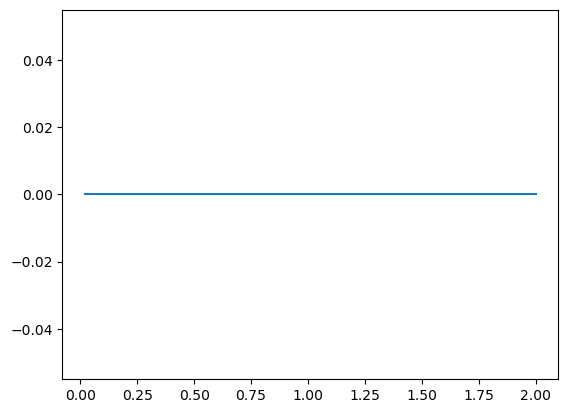

In [4]:
plt.plot(betas[1::],np.diff(np.array(Z_list))/np.diff(betas))

In [ ]:
#Z_list

#plt.plot(betas[1::],np.diff(np.array(Z_list))/np.diff(betas))

n = 10
d = 4

bet = 1

def W(na,beta):
    c = - np.log(K(beta)/N) * ((n**d)*d*(d-1)/2 - na)
    arr = np.zeros((N,N),dtype=complex)
    for i in range(N):
        for j in range(N):
            arr[i,j] = I(i,j,beta)
    return c - np.log(np.real(np.trace(np.linalg.matrix_power(arr,na))))

W(10,20) 

In [ ]:
L = []

num_cores = multiprocessing.cpu_count()
plaqs = np.arange(4,20,2)

betas = np.linspace(0,30,10)

for beta in tqdm(betas):
    with Parallel(n_jobs=num_cores) as parallel:
        W_list = parallel(delayed(lambda na: W(na,beta))(plaq) for plaq in plaqs)
    L.append(W_list)

In [ ]:
for i in range(1,len(L)):
    plt.plot(plaqs,elem/np.sqrt(plaqs))

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 71.28it/s]


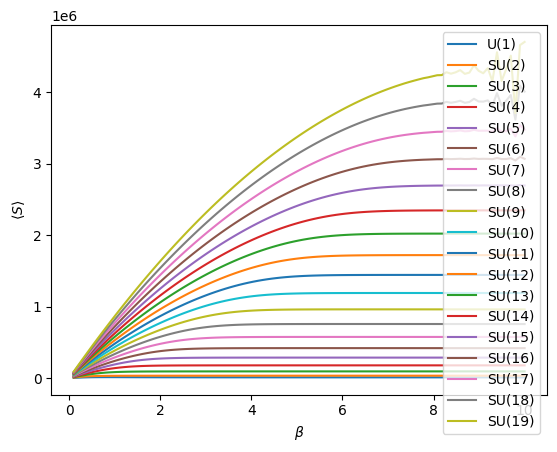

'\nV(10,2,3)\n\nnum_cores = multiprocessing.cpu_count()\n\nwith Parallel(n_jobs=num_cores) as parallel:\n    ls = parallel(delayed(lambda r:V(r,10,2))(r) for r in tqdm(np.arange(4,101)))\n\nplt.plot(np.arange(4,101),ls)\n'

In [53]:
from math import factorial
from scipy.special import gamma

def bessel(x,n):
    y = x/2
    s = 0
    for k in range(50):
        if n > 0:
            s += y**(2*k+n)/(factorial(k) * gamma(k+n+1))
        else:
            s += y**(2*k-n)/(factorial(k) * gamma(k-n+1))
    return s

def bessel_deriv(x,n):
    y = x/2
    s = 0
    for k in range(20):
        if n > 0:
            s += (2*k+n) * y**(2*k+n-1)/(factorial(k) * gamma(k+n+1))
        else:
            s += (2*k+n) * y**(2*k-n-1)/(factorial(k) * gamma(k-n+1))
    return s
    

def Z_log(beta,N,d,n):
    if N == 1:
        return - n**d * d * (d-1)/2 * (np.log(bessel(2*beta,0)) - 2*beta*N)
    else:
        s = 0
        for l in range(50):
            arr = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    arr[i,j] = bessel(2*beta,l+j-i)
            if l == 0:
                s += np.linalg.det(arr)
            else:
                arr1 = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        arr1[i,j] = bessel(2*beta,-l+j-i)
                s += (np.linalg.det(arr1) + np.linalg.det(arr))
        return - n**d * d * (d-1)/2 * (np.log(s) - 2*beta*N)

def foo(beta,N):
    if N == 1:
        return np.log(bessel_deriv(2*beta,0)) - 2 * N * beta
    else:
        s = 0
        for l in range(20):
            arr = np.zeros((N,N))
            arr_deriv = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    arr[i,j] = bessel(2*beta,l+j-i)
                    arr_deriv[i,j] = bessel_deriv(2*beta,l+j-i)
            if l == 0:
                adj = np.array((sp.Matrix(arr).adjugate()),dtype=float)
                s += np.trace(np.matmul(adj,arr_deriv))
            else:
                arr1 = np.zeros((N,N))
                arr1_deriv = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        arr1[i,j] = bessel(2*beta,-l+j-i)
                        arr1_deriv[i,j] = bessel_deriv(2*beta,-l+j-i)
                adj = np.array((sp.Matrix(arr).adjugate()),dtype=float)
                adj1 = np.array((sp.Matrix(arr1).adjugate()),dtype=float)
                s += (np.trace(np.matmul(adj,arr_deriv)) + np.trace(np.matmul(adj1,arr1_deriv)))
        return np.log(s/N) - 2 * N * beta

def V(r,beta,N):
    return - 1/r * (np.log(N) + r**2 * foo(beta,N))
    
#energy = np.vectorize(lambda beta:Z_log(beta,2,2,10))
betas = np.linspace(0,10,100)

def plot_N(N,d,n):
    energy = np.vectorize(lambda beta:Z_log(beta,N,d,n))
    energy = betas[1::]*np.diff(energy(betas))/np.diff(betas)
    return energy

L = []

end = 20

num_cores = multiprocessing.cpu_count()

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(lambda N:plot_N(N,3,20))(N) for N in tqdm(np.arange(1,end)))

for i in range(len(ls)):
    L.append(-ls[i][-1]/(20**2 * 3))
    if i == 0:
        plt.plot(betas[1::],ls[i],label='U(1)')
    else:
        plt.plot(betas[1::],ls[i],label= 'SU(' + f'{i+1}' + ')')
        
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle S \rangle$')
plt.legend()
plt.savefig('MFenergy.png')
plt.show()

'''
V(10,2,3)

num_cores = multiprocessing.cpu_count()

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(lambda r:V(r,10,2))(r) for r in tqdm(np.arange(4,101)))

plt.plot(np.arange(4,101),ls)
'''

2.995732273553991


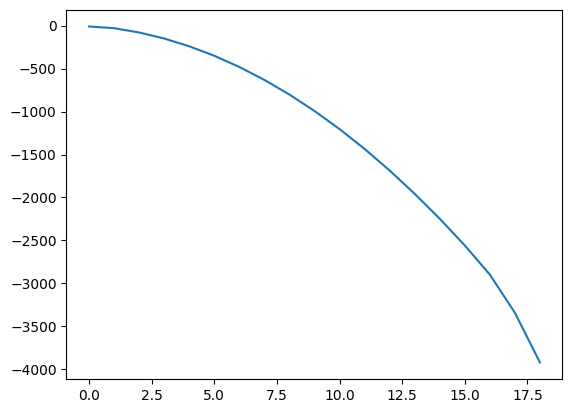

In [55]:
plt.plot(L)
print(np.log(20))

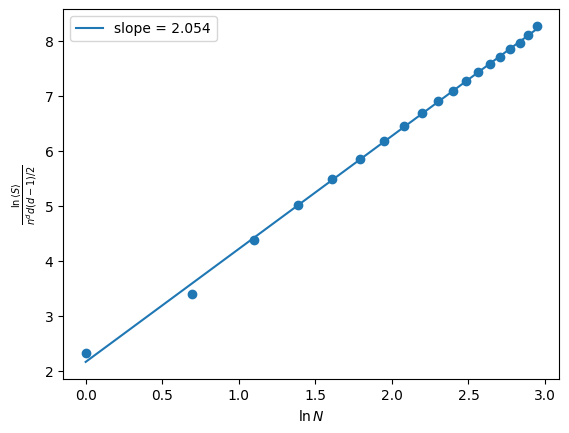

(2.054000181855131, 2.166440603937593, -0.8047189562170501)

In [56]:
#plt.plot(np.arange(1,20),np.log(np.log(np.array(L))))
arr = - np.array(L)[::]
argu = np.arange(1,end)
#plt.scatter(argu,arr)
plt.scatter(np.log(argu),np.log(arr))
a, b = np.polyfit(np.log(argu),np.log(arr),1)
plt.plot(np.log(argu),a*np.log(argu)+b,label='slope = ' + f'{round(a,3)}')
plt.legend()
#b = np.exp(b)

#plt.plot(argu,b*argu**a)
#plt.scatter(argu,arr)
a,np.exp(b)
plt.xlabel(r'$\ln N$')
plt.ylabel(r'$\frac{\ln \langle S \rangle}{n^d d(d-1)/2} $')
#plt.savefig('Linear_fit.png')
plt.show()
a,b, -np.log(5)/2

In [77]:
a,b

(2.1007898701270653, 39.05772534897879)

In [75]:
39*3**2

351

In [107]:
np.log(10)

2.302585092994046

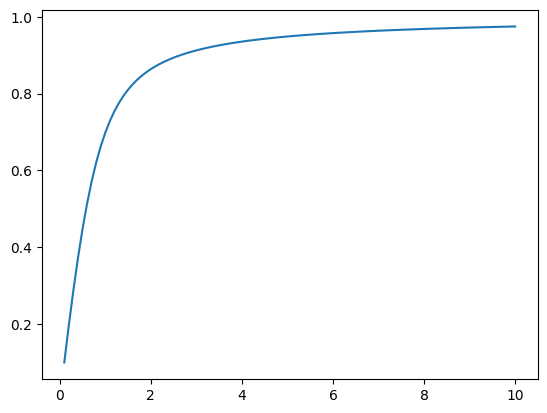

In [7]:
from math import factorial
from scipy.special import gamma

def funky(beta):
    s = 0
    for k in range(50):
        s += beta**(2*k+1)/(factorial(k) * factorial(k+1))
    return s

def bar(beta):
    s = 0
    for k in range(50):
        s += beta**(2*k)/(factorial(k)**2)
    return s

funk_vec = np.vectorize(funky)
bar_vec = np.vectorize(bar)

betas = np.linspace(0.1,10,100)
plt.plot(betas,funk_vec(betas)/bar_vec(betas))

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 56.67it/s]


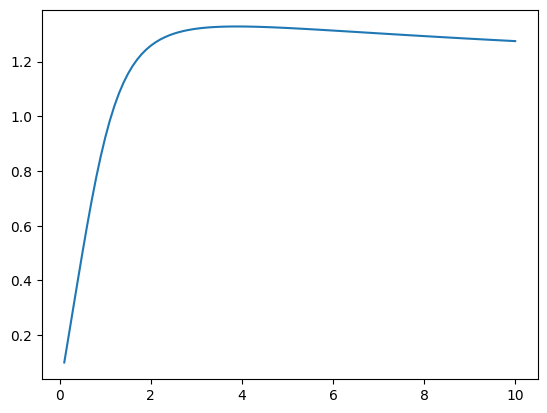

In [26]:
max_iter = 30

def bessel(x,n):
    y = x/2
    s = 0
    for k in range(max_iter):
        if n > 0:
            s += y**(2*k+n)/(factorial(k) * gamma(k+n+1))
        else:
            s += y**(2*k-n)/(factorial(k) * gamma(k-n+1))
    return s

def bessel_deriv(x,n):
    y = x/2
    s = 0
    for k in range(max_iter):
        if n > 0:
            s += (2*k+n) * y**(2*k+n-1)/(factorial(k) * gamma(k+n+1))
        else:
            s += (2*k+n) * y**(2*k-n-1)/(factorial(k) * gamma(k-n+1))
    return s/2
    

def den(beta,N):
    if N == 1:
        return bessel(2*beta,0)
    else:
        s = 0
        for l in range(max_iter):
            arr = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    arr[i,j] = bessel(2*beta,l+j-i)
            if l == 0:
                s += np.linalg.det(arr)
            else:
                arr1 = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        arr1[i,j] = bessel(2*beta,-l+j-i)
                s += (np.linalg.det(arr1) + np.linalg.det(arr))
        return s

def num(beta,N):
    if N == 1:
        return bessel_deriv(2*beta,0)
    else:
        s = 0
        for l in range(max_iter):
            arr = np.zeros((N,N))
            arr_deriv = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    arr[i,j] = bessel(2*beta,l+j-i)
                    arr_deriv[i,j] = bessel_deriv(2*beta,l+j-i)
            if l == 0:
                adj = np.array((sp.Matrix(arr).adjugate()),dtype=float)
                s += np.trace(np.matmul(adj,arr_deriv))
            else:
                arr1 = np.zeros((N,N))
                arr1_deriv = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        arr1[i,j] = bessel(2*beta,-l+j-i)
                        arr1_deriv[i,j] = bessel_deriv(2*beta,-l+j-i)
                adj = np.array((sp.Matrix(arr).adjugate()),dtype=float)
                adj1 = np.array((sp.Matrix(arr1).adjugate()),dtype=float)
                s += (np.trace(np.matmul(adj,arr_deriv)) + np.trace(np.matmul(adj1,arr1_deriv)))
        return s/N
    
#den_vec = np.vectorize(lambda beta:den(beta,3))
#num_vec = np.vectorize(lambda beta:num(beta,3))

betas = np.linspace(0.1,10,100)

#plt.plot(betas,num_vec(betas)/den_vec(betas))

num_cores = multiprocessing.cpu_count()

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(lambda beta:num(beta,3)/den(beta,3))(beta) for beta in tqdm(betas))

plt.plot(betas,ls)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 67.99it/s]
/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_16965/2893866050.py:40: RuntimeWarning: overflow encountered in matmul
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1774: RuntimeWarning: invalid value encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_16965/2893866050.py:50: RuntimeWarning: overflow encountered in matmul
/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_16965/2893866050.py:40: RuntimeWarning: overflow encountered in matmul
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1774: RuntimeWarning: invalid value encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/var/folders/h7/_hqqwrk517z46v06lptyq1580

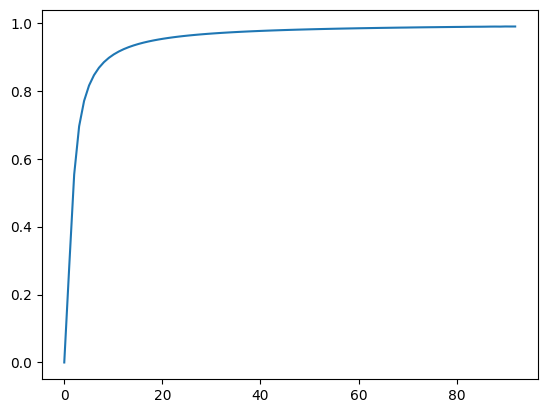

In [60]:
from scipy.special import iv

max_iter = 30


def den(beta,N):
    if N == 1:
        return iv(0,2*beta)
    else:
        s = 0
        for l in range(max_iter):
            arr = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    arr[i,j] = iv(l+j-i,2*beta)
            if l == 0:
                s += np.linalg.det(arr)
            else:
                arr1 = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        arr1[i,j] = iv(-l+j-i,2*beta)
                s += (np.linalg.det(arr1) + np.linalg.det(arr))
        return s

def num(beta,N):
    if N == 1:
        return iv(1,2*beta)
    else:
        s = 0
        for l in range(max_iter):
            arr = np.zeros((N,N))
            arr_deriv = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    arr[i,j] = iv(l+j-i,2*beta)
                    arr_deriv[i,j] = iv(l+j-i+1,2*beta)
            if l == 0:
                adj = np.array((sp.Matrix(arr).adjugate()),dtype=float)
                s += np.trace(np.matmul(adj,arr_deriv))
            else:
                arr1 = np.zeros((N,N))
                arr1_deriv = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        arr1[i,j] = iv(-l+j-i,2*beta)
                        arr1_deriv[i,j] = iv(-l+j-i+1,2*beta)
                adj = np.array((sp.Matrix(arr).adjugate()),dtype=float)
                adj1 = np.array((sp.Matrix(arr1).adjugate()),dtype=float)
                s += (np.trace(np.matmul(adj,arr_deriv)) + np.trace(np.matmul(adj1,arr1_deriv)))
        return s/N
    
#den_vec = np.vectorize(lambda beta:den(beta,3))
#num_vec = np.vectorize(lambda beta:num(beta,3))

betas = np.linspace(0,100,100)

#plt.plot(betas,num_vec(betas)/den_vec(betas))

num_cores = multiprocessing.cpu_count()

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(lambda beta:num(beta,4)/den(beta,4))(beta) for beta in tqdm(betas))

plt.plot(betas,ls)

In [56]:
num(4.8,2)/den(4.8,2)

0.9229492231099644